In [175]:
import sys
# setting path
sys.path.append('..')

In [176]:
import numpy as np
import matplotlib.pyplot as plt

from src import io, var, utils, fourier, lin_reg, reconstruction
from vis import plotter

import importlib
importlib.reload(io)
importlib.reload(var)
importlib.reload(utils)
importlib.reload(fourier)
importlib.reload(lin_reg)
importlib.reload(reconstruction)

importlib.reload(plotter)

<module 'vis.plotter' from '/home/ray/git-projects/spec_appx/notebooks/../vis/plotter.py'>

In [177]:
grid = var.grid()
topo = var.topo()
cell = var.topo_cell()

reader = io.ncdata()
fn = '../data/icon_compact.nc'
reader.read_dat(fn, grid)
grid.apply_f(utils.rad2deg)

fn = '../data/topo_compact.nc'
reader.read_dat(fn, topo)

lat_verts = np.array([52.,64.,64.])
lon_verts = np.array([-141.,-158.,-127.])

reader.read_topo(topo, cell, lon_verts, lat_verts)

Data fetched...


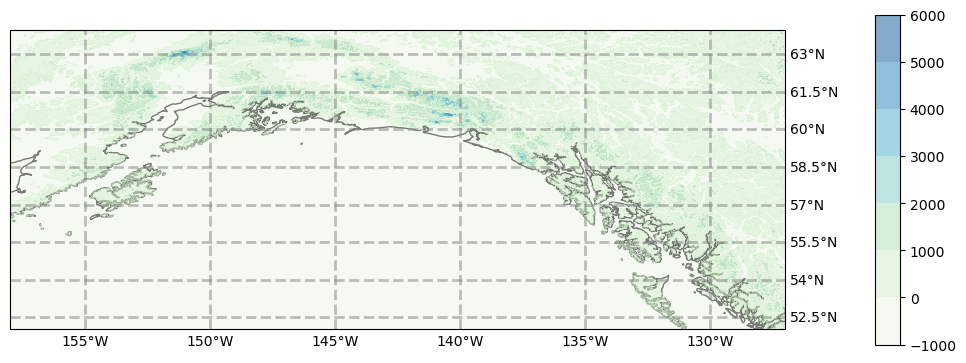

In [160]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

cell.gen_mgrids()

fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines()
im = ax.contourf(cell.lon_grid, cell.lat_grid, cell.topo,
            alpha=0.5,
            transform=ccrs.PlateCarree(),
            cmap='GnBu',
            # vmin=0.0,
            # vmax=3000.0
            )

cax = fig.add_axes([0.99, 0.22, 0.025, 0.55])
fig.colorbar(im, cax=cax)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = False

gl.xlocator = LongitudeLocator()
gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter(auto_hide=False)
gl.yformatter = LatitudeFormatter()

ax.tick_params(axis="both",
               tickdir='out',
               length=15,
               grid_transform=ccrs.PlateCarree())

plt.show()


(1440, 3720)


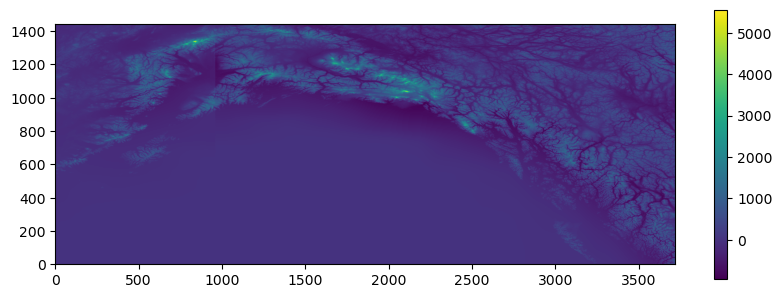

In [161]:
print(cell.lat_grid.shape)

plt.figure(figsize=(10,3.5))
plt.imshow(cell.topo, origin='lower')
plt.colorbar()
plt.show()

(1440, 3720)


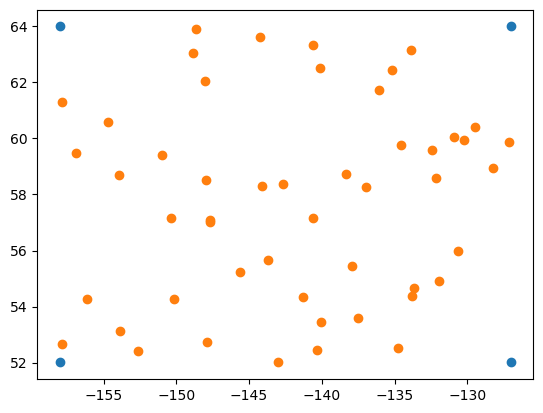

In [162]:
# A = np.arange(100).reshape(10,10)
# print(A)


# B = np.array_split(A, 2)
# print(B)

print(cell.lat_grid.shape)

np.random.seed(100)
rand_lat_idx = np.random.randint(len(cell.lat), size=50)
rand_lon_idx = np.random.randint(len(cell.lon), size=50)

# print(rand_lat_idx)
# print(rand_lon_idx)



# print(rand_idxs)

lat_verts = cell.lat_grid[rand_lat_idx, rand_lon_idx]
lon_verts = cell.lon_grid[rand_lat_idx, rand_lon_idx]

lat_min = cell.lat.min()
lat_max = cell.lat.max()
lon_min = cell.lon.min()
lon_max = cell.lon.max()

lon_corners = [lon_min, lon_min, lon_max, lon_max]
lat_corners = [lat_min, lat_max, lat_max, lat_min]

plt.figure()
plt.plot(lon_corners,lat_corners, 'o')
plt.plot(lon_verts, lat_verts, 'o')
plt.show()

full_lat_verts = np.append(lat_corners, lat_verts)
full_lon_verts = np.append(lon_corners, lon_verts)

points = np.array([list(item) for item in zip(full_lat_verts, full_lon_verts)])

In [121]:
print(len(cell.lat))
print(len(cell.lon))

1440
3720


In [163]:
import matplotlib.tri as tri

xlen = len(cell.lon)
ylen = len(cell.lat)
xPoints = np.linspace(0,xlen-1,11)
yPoints = np.linspace(0,ylen-1,6)

YY,XX = np.meshgrid(yPoints,xPoints)

points = np.array([list(item) for item in zip(XX.ravel(), YY.ravel())]).astype('int')

lat_verts = cell.lat_grid[points[:,1], points[:,0]]
lon_verts = cell.lon_grid[points[:,1], points[:,0]]

points = np.array([list(item) for item in zip(lon_verts, lat_verts)])

lats = points[:,1]
lons = points[:,0]

100
100


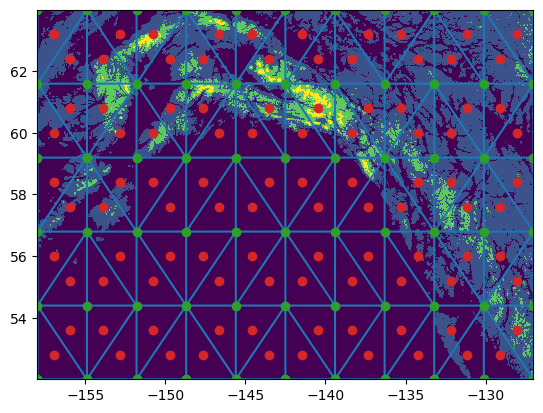

In [203]:
from scipy.spatial import Delaunay

tri = Delaunay(points)

tri_lat_verts = lats[tri.simplices]
tri_lon_verts = lons[tri.simplices]

print(len(tri_lat_verts))

# compute centroid
tri_clats = tri_lat_verts.sum(axis=1) / 3.0
tri_clons = tri_lon_verts.sum(axis=1) / 3.0

print(len(tri_clats))


plt.figure()
plt.contourf(cell.lon_grid, cell.lat_grid, cell.topo, vmin=0.0, vmax=2000.0)
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.plot(tri_clons, tri_clats, 'o')
plt.show()

# p = np.array([(-142, 58), (1.5, 0.5), (0.5, 1.05)])

# tri.find_simplex(p)

# print((tri.simplices))

In [236]:
import numba as nb

float64 = nb.float64
boolean = nb.boolean
int32 = nb.int32


def mask_wrapper(polygon):
    return lambda p : is_inside_sm(p, polygon)


@nb.njit
def is_inside_sm(point, polygon):
    length = len(polygon)-1
    dy2 = point[1] - polygon[0][1]
    intersections = 0
    ii = 0
    jj = 1

    while ii<length:
        dy  = dy2
        dy2 = point[1] - polygon[jj][1]

        # consider only lines which are not completely above/bellow/right from the point
        if dy*dy2 <= 0.0 and (point[0] >= polygon[ii][0] or point[0] >= polygon[jj][0]):

            # non-horizontal line
            if dy<0 or dy2<0:
                F = dy*(polygon[jj][0] - polygon[ii][0])/(dy-dy2) + polygon[ii][0]

                if point[0] > F: # if line is left from the point - the ray moving towards left, will intersect it
                    intersections += 1
                elif point[0] == F: # point on line
                    return 2

            # point on upper peak (dy2=dx2=0) or horizontal line (dy=dy2=0 and dx*dx2<=0)
            elif dy2==0 and (point[0]==polygon[jj][0] or (dy==0 and (point[0]-polygon[ii][0])*(point[0]-polygon[jj][0])<=0)):
                return 2

        ii = jj
        jj += 1

    #print 'intersections =', intersections
    return intersections & 1  


In [250]:
idx = 99
tri_lat_verts = lats[tri.simplices]
tri_lon_verts = lons[tri.simplices]

circ_tri_lat_verts = np.hstack((tri_lat_verts,tri_lat_verts[:,0].reshape(-1,1)))
circ_tri_lon_verts = np.hstack((tri_lon_verts,tri_lon_verts[:,0].reshape(-1,1)))

# circ_tri_lat_verts = tri_lat_verts
# circ_tri_lon_verts = tri_lon_verts

circ_tri_lon_verts = rescale(circ_tri_lon_verts)
circ_tri_lat_verts = rescale(circ_tri_lat_verts)

# print(circ_tri_lat_verts)
# print(circ_tri_lon_verts)
# print(tri_lat_verts)
# print(tri_lat_verts[:,0].reshape(-1,1))
simplex_lat = circ_tri_lat_verts[idx]
simplex_lon = circ_tri_lon_verts[idx]

polygon = np.array([list(item) for item in zip(simplex_lon, simplex_lat)])

print(polygon)

# print(polygon)

init_poly = mask_wrapper(polygon)
# vec_masker = np.vectorize(init_poly)
tf_array = np.array([init_poly(elem) for elem in lat_lon_mgrid])

[[0.39983851 0.59972216]
 [0.39983851 0.79986092]
 [0.29981192 0.59972216]
 [0.39983851 0.59972216]]


(5356800, 2)
(1440, 3720)


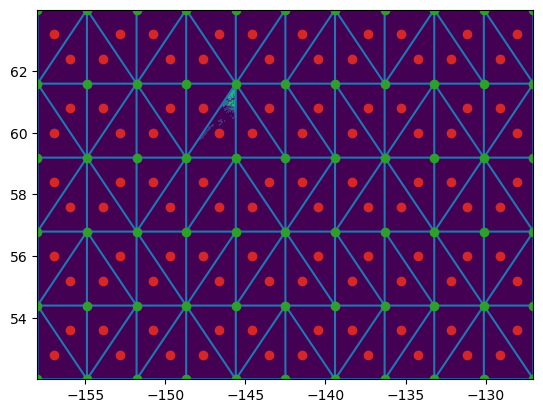

In [252]:
cell.gen_mgrids()

lat_grid_tmp = np.expand_dims(cell.lat_grid,-1)
lon_grid_tmp = np.expand_dims(cell.lon_grid,-1)
                
def rescale(arr):
    arr -= arr.min()
    arr /= arr.max()
    
    return arr

lat_grid_tmp = rescale(lat_grid_tmp)
lon_grid_tmp = rescale(lon_grid_tmp)

lat_lon_mgrid = np.stack((lon_grid_tmp, lat_grid_tmp), axis=2).reshape(-1,2)
print(lat_lon_mgrid.shape)

tf_array = tf_array.reshape(cell.lon_grid.shape[0],cell.lon_grid.shape[1])

print(tf_array.shape)

cell.gen_mgrids()

plt.figure()
plt.contourf(cell.lon_grid, cell.lat_grid, cell.topo*tf_array, vmin=0.0, vmax=2000.0)
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.plot(tri_clons, tri_clats, 'o')
plt.show()

(array([575, 719]), array([2975, 2789]))